In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval()

# Load an image containing faces
img = Image.open('fake.007545.jpg')

# Detect faces in the image
boxes, _ = mtcnn.detect(img)

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from facenet_pytorch import MTCNN
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import matplotlib.pyplot as plt
import numpy as np
import random



class DeepfakeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None, resize=256):
        """
        root_dir (string): Directorio con todas las imágenes, organizadas en subdirectorios 'real' y 'fake'.
        transform (callable, optional): Opcional transformación para ser aplicada en una cara.
        resize (int): Tamaño al cual se redimensionará la cara detectada.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.mtcnn = MTCNN(keep_all=True)
        self.data = []
        self.labels = []

        # Cargar los datos
        for label, cls in enumerate(['real', 'fake']):
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img_name)
                self.load_image_faces(img_path, label)

    def load_image_faces(self, img_path, label):
        img = Image.open(img_path)
        boxes, _ = self.mtcnn.detect(img)
        if boxes is not None:
            for box in boxes:  # Procesar todas las caras detectadas
                face = img.crop(box).resize((self.resize, self.resize))
                self.data.append(face)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        face = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            face = self.transform(face)

        return face, label


# Ejemplo de uso
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte los parches PIL a tensores de PyTorch
    transforms.RandomHorizontalFlip(),  # Aplica un giro horizontal aleatorio
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    #transforms.RandomRotation(degrees=10),  # Rota la imagen ±20 grados aleatoriamente

    # Añade aquí cualquier otra transformación que necesites
])
train_set = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Image-Classification-Using-Vision-transformer-main/Task_1/development', transform=transform)
val_set = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Image-Classification-Using-Vision-transformer-main/Task_1/development_val', transform=transform)
dataloader = DataLoader(train_set, batch_size=1, shuffle=True)




def set_seed(seed=1):
    """Establece la semilla para reproducibilidad."""
    random.seed(seed)  # Python random
    np.random.seed(seed)  # Numpy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # Para GPU
    torch.cuda.manual_seed_all(seed)  # Para todas las GPU
    torch.backends.cudnn.deterministic = True  # Determinístico donde sea posible
    torch.backends.cudnn.benchmark = False  # Usar algoritmos determinísticos

set_seed(42)  # Puedes usar cualquier número como semilla


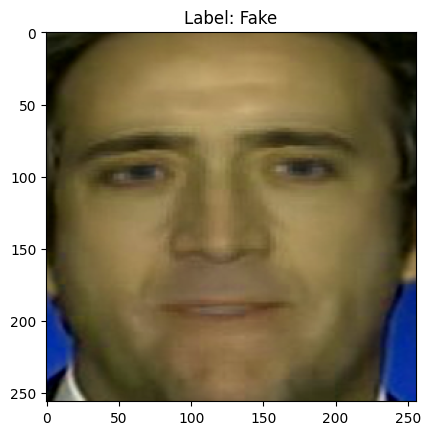

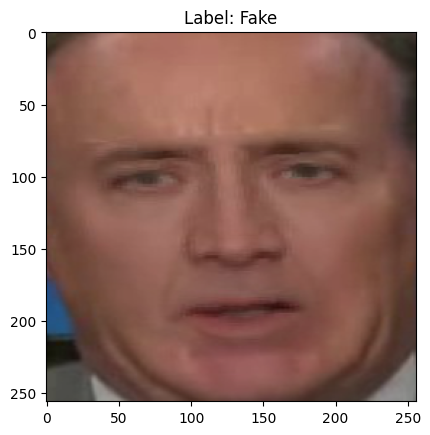

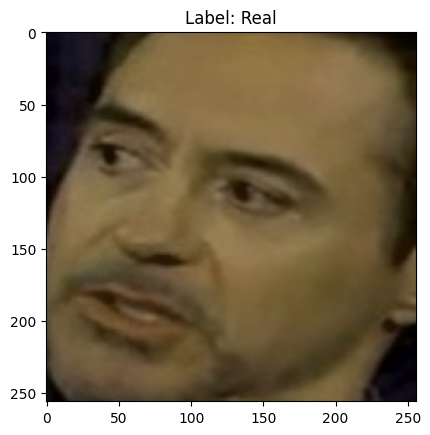

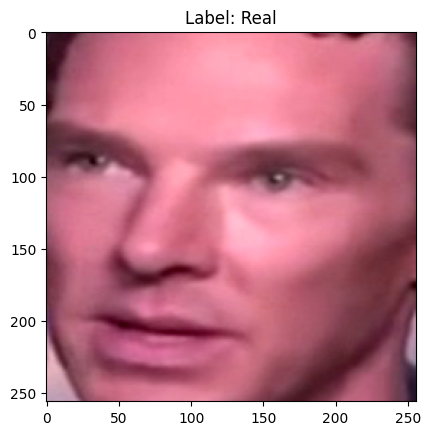

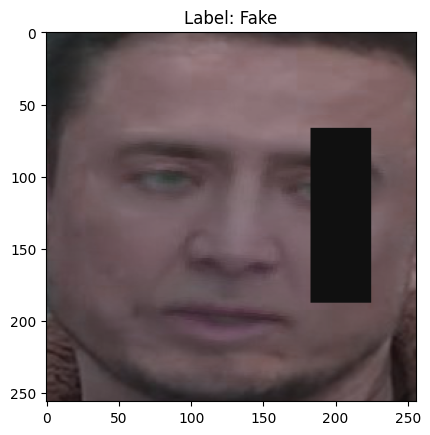

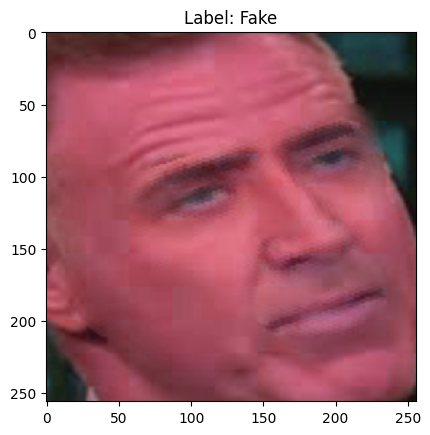

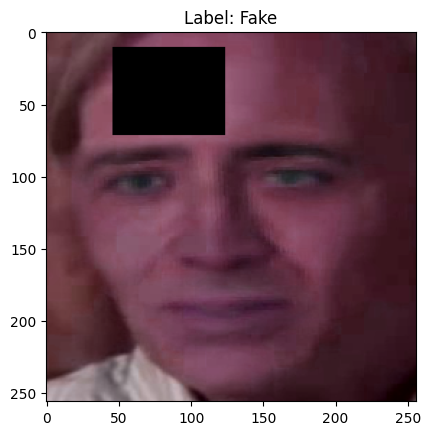

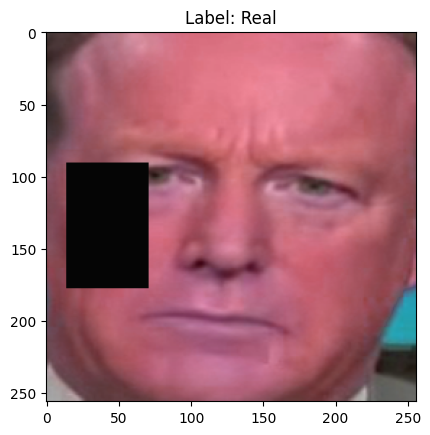

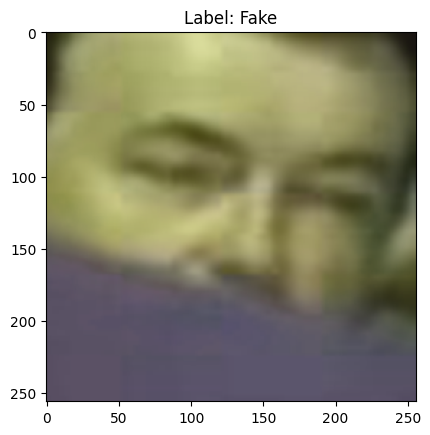

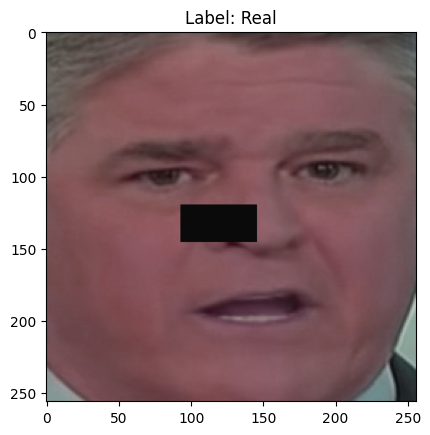

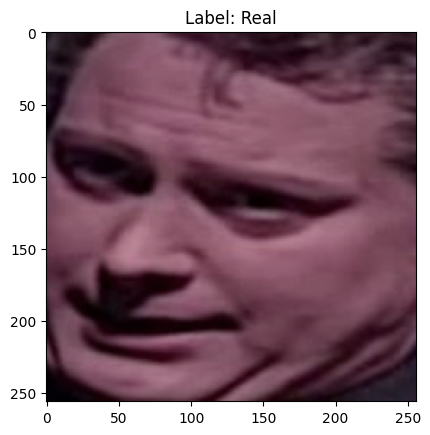

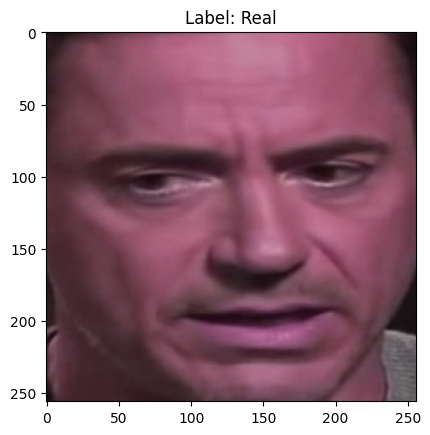

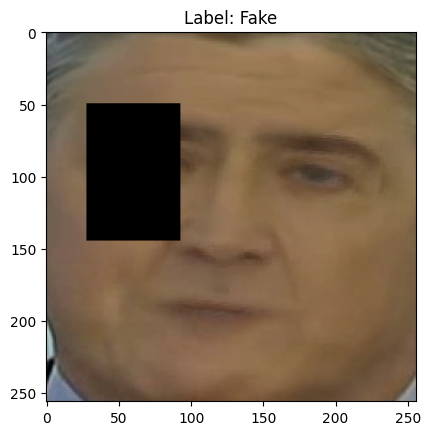

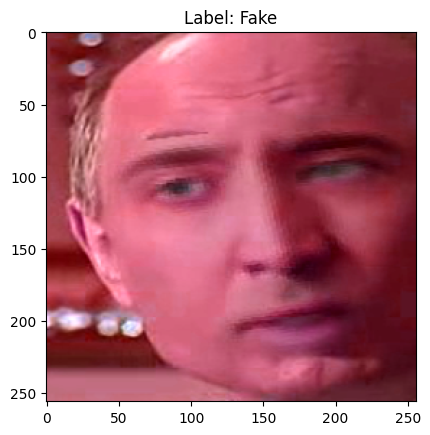

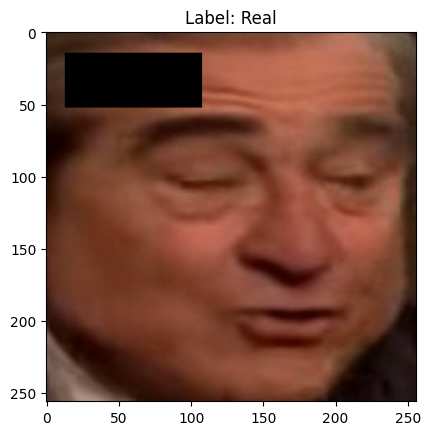

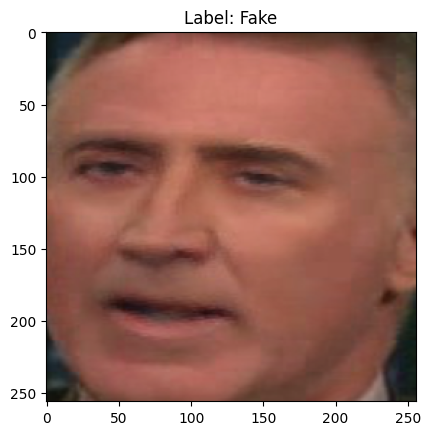

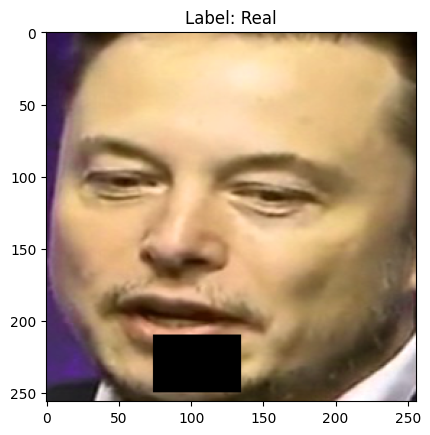

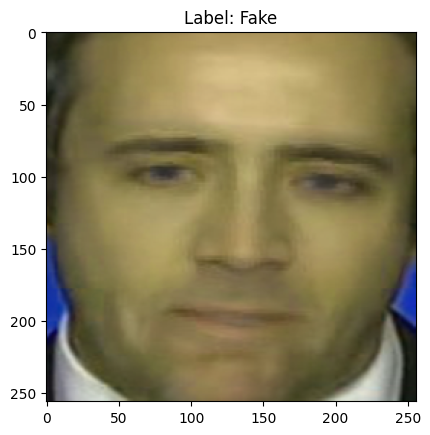

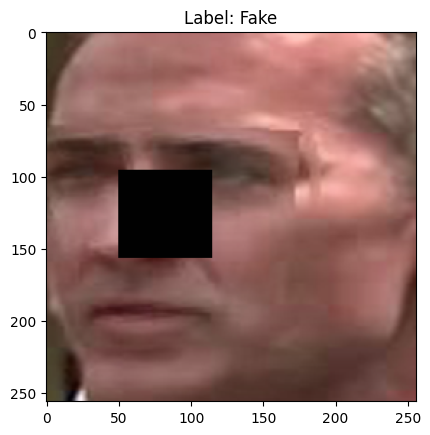

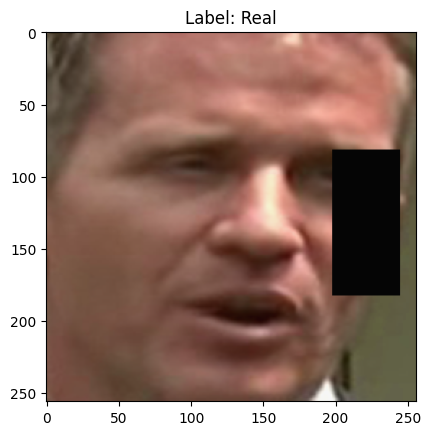

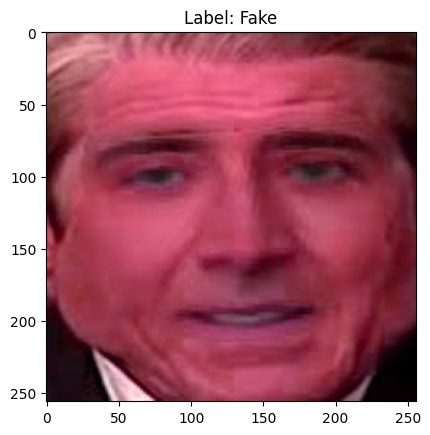

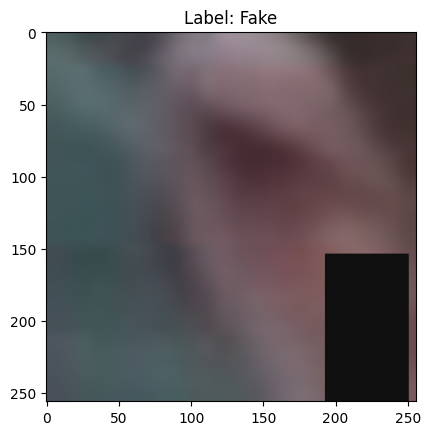

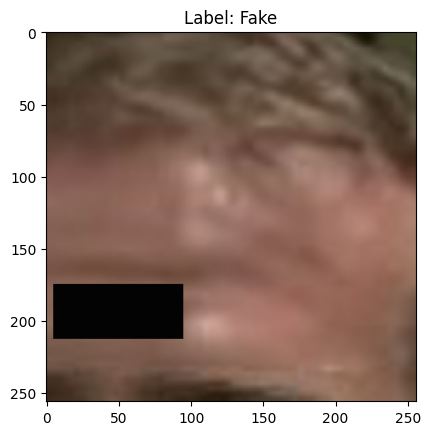

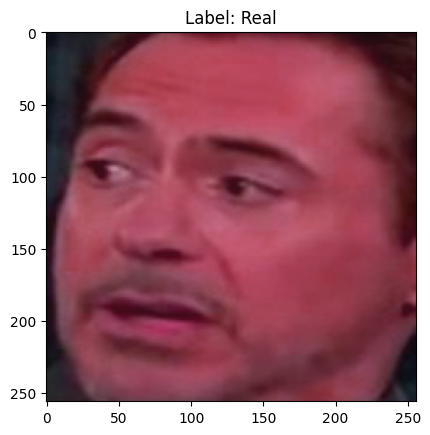

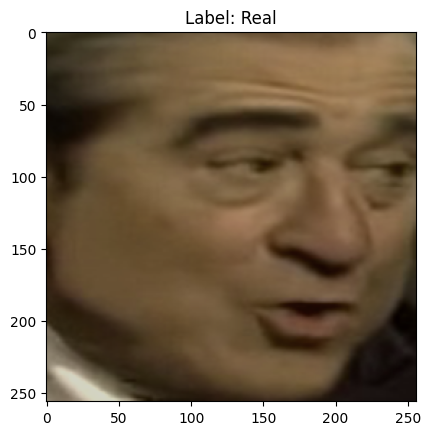

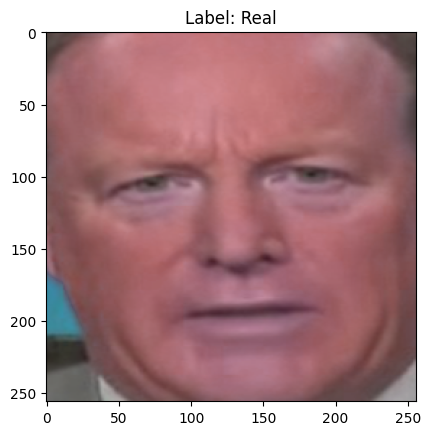

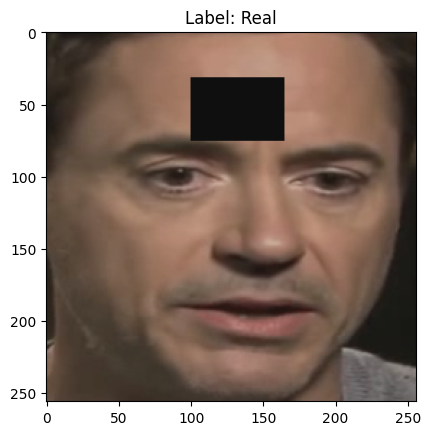

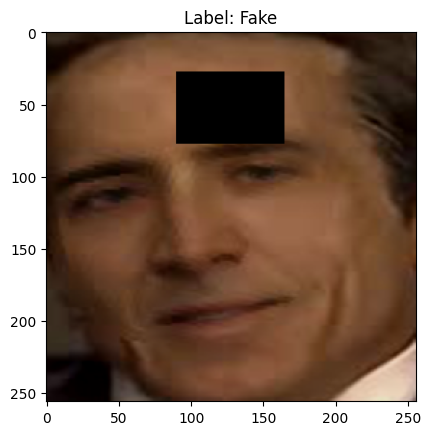

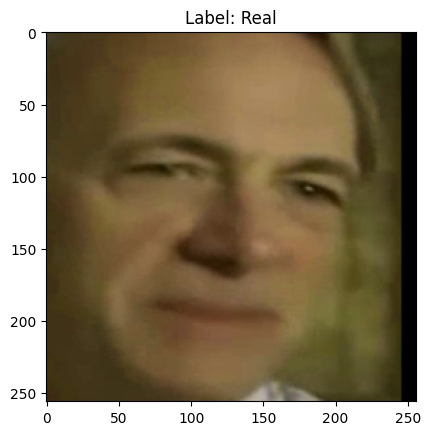

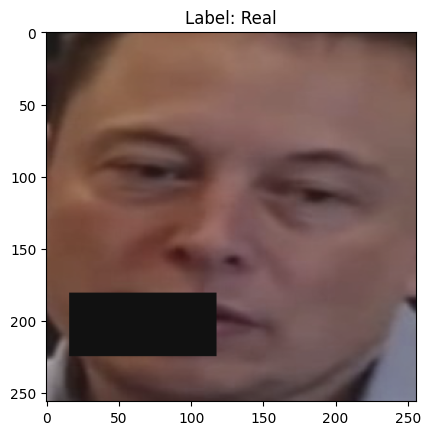

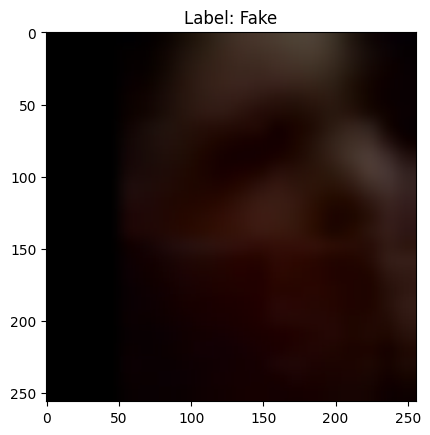

In [3]:
# Iterar sobre el DataLoader
i = 0
for patches, labels in dataloader:
    if i > 30:
        break
    patch = patches.squeeze(0)  # Elimina la dimensión del batch
    plt.imshow(patch.numpy().transpose(1, 2, 0))  # Muestra el parche
    plt.title(f'Label: {"Real" if labels.item() == 0 else "Fake"}')  # Muestra la etiqueta
    plt.show()
    i += 1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader


In [6]:
from torch.utils.data import DataLoader

# Parámetros del DataLoader
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)




In [7]:
def initialize_model(num_classes):
    # Cargar modelo ResNet-18 sin pesos preentrenados
    model = models.resnet18(pretrained=False)
    
    # Obtener el número de características de entrada de la última capa lineal
    num_ftrs = model.fc.in_features
    
    # Reemplazar la última capa lineal por una nueva que se ajuste al número de clases (2 en este caso)
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Inicializar el modelo
model = initialize_model(num_classes=2).to(device)


C:\Users\X571\anaconda3\envs\gpu_pytorch3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\X571\anaconda3\envs\gpu_pytorch3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
def adjust_learning_rate(optimizer, epoch):
    """Ajusta el learning rate del optimizador al nuevo valor si estamos en el epoch especificado."""
    if epoch == 10:  # Ajustar el lr en este epoch
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0005
            
    elif epoch == 20:  # Ajustar el lr en este epoch
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001



def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Listas para almacenar los resultados
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        adjust_learning_rate(optimizer, epoch+1)  # epoch+1 para que coincida con tu conteo
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Bucle de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Bucle de validación
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs
    
train_losses, val_losses, train_accs, val_accs=train_model(model, criterion, optimizer ,train_loader, val_loader, num_epochs=30)

Epoch 1/30 Train Loss: 0.8726 Acc: 0.5174 Val Loss: 0.7308 Acc: 0.5062
Epoch 2/30 Train Loss: 0.7029 Acc: 0.5401 Val Loss: 0.7233 Acc: 0.4938
Epoch 3/30 Train Loss: 0.6658 Acc: 0.6203 Val Loss: 0.6225 Acc: 0.6438
Epoch 4/30 Train Loss: 0.5641 Acc: 0.7216 Val Loss: 0.5734 Acc: 0.7438
Epoch 5/30 Train Loss: 0.4524 Acc: 0.7943 Val Loss: 0.7760 Acc: 0.6875
Epoch 6/30 Train Loss: 0.4201 Acc: 0.8079 Val Loss: 0.5872 Acc: 0.7375
Epoch 7/30 Train Loss: 0.3336 Acc: 0.8563 Val Loss: 0.9029 Acc: 0.6875
Epoch 8/30 Train Loss: 0.3313 Acc: 0.8593 Val Loss: 2.3035 Acc: 0.5563
Epoch 9/30 Train Loss: 0.2410 Acc: 0.9017 Val Loss: 0.4076 Acc: 0.8438
Epoch 10/30 Train Loss: 0.2141 Acc: 0.9198 Val Loss: 0.4281 Acc: 0.8625
Epoch 11/30 Train Loss: 0.1560 Acc: 0.9319 Val Loss: 0.9392 Acc: 0.7188
Epoch 12/30 Train Loss: 0.1847 Acc: 0.9304 Val Loss: 0.3455 Acc: 0.8438
Epoch 13/30 Train Loss: 0.1543 Acc: 0.9274 Val Loss: 0.3773 Acc: 0.8313
Epoch 14/30 Train Loss: 0.1190 Acc: 0.9501 Val Loss: 0.1520 Acc: 0.9375
E

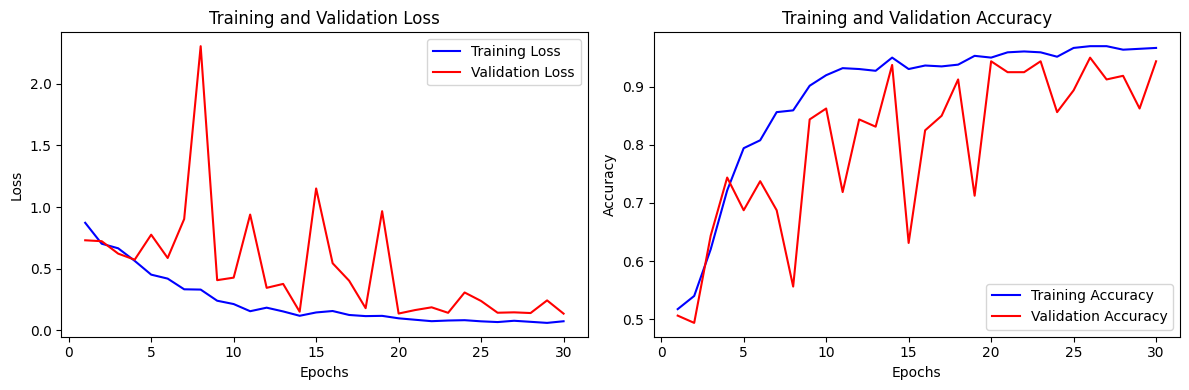

In [10]:
import numpy as np
def plot_results(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Convertir a arrays de NumPy después de asegurarse de que están en CPU si son tensores
    if isinstance(train_losses[0], torch.Tensor):
        train_losses_np = np.array([loss.item() for loss in train_losses])
    else:
        train_losses_np = np.array(train_losses)
    
    if isinstance(val_losses[0], torch.Tensor):
        val_losses_np = np.array([loss.item() for loss in val_losses])
    else:
        val_losses_np = np.array(val_losses)
    
    if isinstance(train_accs[0], torch.Tensor):
        train_accs_np = np.array([acc.item() for acc in train_accs])
    else:
        train_accs_np = np.array(train_accs)
    
    if isinstance(val_accs[0], torch.Tensor):
        val_accs_np = np.array([acc.item() for acc in val_accs])
    else:
        val_accs_np = np.array(val_accs)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, 'b-', label='Training Loss')  # Líneas sólidas azules
    plt.plot(epochs, val_losses_np, 'r-', label='Validation Loss')  # Líneas sólidas rojas
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs_np, 'b-', label='Training Accuracy')  # Líneas sólidas azules
    plt.plot(epochs, val_accs_np, 'r-', label='Validation Accuracy')  # Líneas sólidas rojas
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_results(train_losses, val_losses, train_accs, val_accs)


## TEST

In [11]:
# Asumiendo que tienes una clase DeepfakePatchDataset
test_dataset = DeepfakeFaceDataset(root_dir='C:/Users/X571/Documents/VIT/Image-Classification-Using-Vision-transformer-main/Task_1/evaluation',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 para procesar cada imagen individualmente


In [12]:
import torch
import numpy as np

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Poner el modelo en modo de evaluación
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Asegurarse de enviar los datos al dispositivo correcto
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  # Obtener las predicciones finales
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')


# Llamar a la función para evaluar el modelo
evaluate_model(model, test_loader)


Accuracy on test set: 0.9488


In [13]:
# Asumiendo que tienes una clase DeepfakePatchDataset
test_dataset = DeepfakeFaceDataset(root_dir='C:/Users/X571\Documents/VIT/Image-Classification-Using-Vision-transformer-main/Task_2_3/evaluation',transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # batch_size=1 para procesar cada imagen individualmente


In [14]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()  # Poner el modelo en modo de evaluación
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Asegurarse de enviar los datos al dispositivo correcto
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, 1)  # Obtener las predicciones finales
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy:.4f}')


# Llamar a la función para evaluar el modelo
evaluate_model(model, test_loader)


Accuracy on test set: 0.6346
